In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 1
seed=67

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
def make_hexagonal_mesh(l):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], -24.0, proliferating=False, division_time_generator=lambda t: 24+t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, delete cell there and replace with proliferating one
    m = n_x *(n_y//2)+ n_x//2
    coords = list(sheet[m].position)
    sheet[m] = cl.Cell(m, coords, -24.0, proliferating=True, division_time_generator=lambda t: 24+t)
    
    return sheet

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

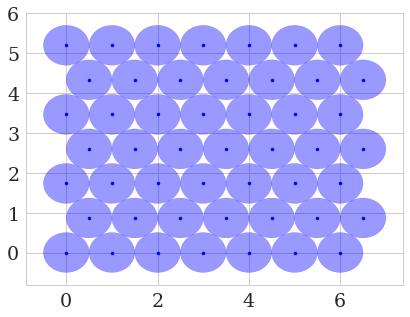

In [7]:
sheet = make_hexagonal_mesh(4)
plot_population(sheet)

# Adaptive time-stepping for two cells after proliferation

In [8]:
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

In [9]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


## Using the Jacobian to obtain the stability bound

Nothing to delete.
Nothing to delete.
Using global adaptive timestepping with a stability bound.
Using global adaptive timestepping with a stability bound.
Using global adaptive timestepping with a stability bound.


(-0.1, 1.2)

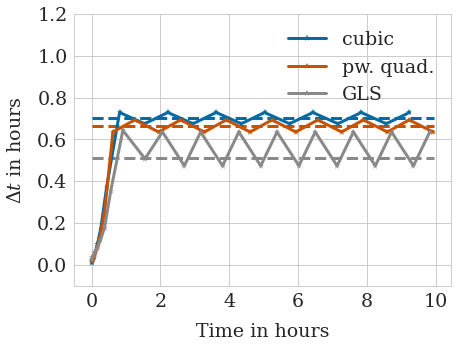

In [10]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])

## No Jacobian - accuracy bound only

Using global adaptive timestepping.
Initial step cubic 0.009898412756172828
Stability bound estimate cubic 0.7037116418303313
Using global adaptive timestepping.
Initial step pw. quad. 0.01659595051288086
Stability bound estimate pw. quad. 0.6658557439110793
Using global adaptive timestepping.
Initial step GLS 0.025608698221123164
Stability bound estimate GLS 0.5548558343167054


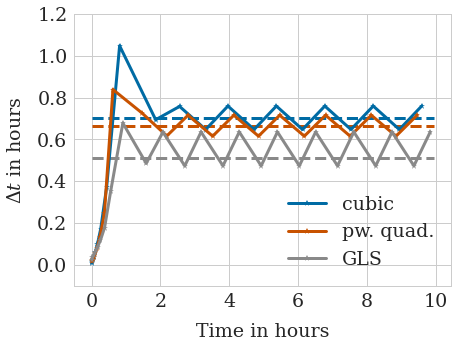

In [11]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_pairwise_relaxation_eps0_01.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

Nothing to delete.
Using global adaptive timestepping.
Initial step cubic 0.003146312345143595
Stability bound estimate cubic 0.7017739704757591
Nothing to delete.
Using global adaptive timestepping.
Initial step pw. quad. 0.005259029485161615
Stability bound estimate pw. quad. 0.663987183476891
Nothing to delete.
Using global adaptive timestepping.
Initial step GLS 0.008126547046893426
Stability bound estimate GLS 0.5162951229243763


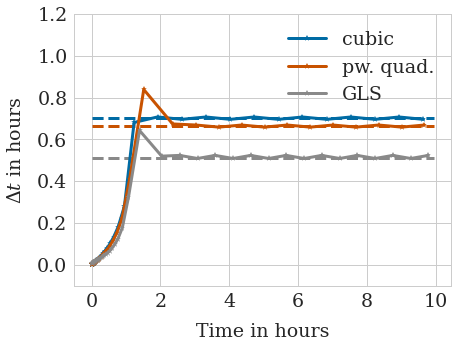

In [12]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_pairwise_relaxation_eps0_001.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


In [13]:
# Accuracy bound for initial step:
eps = 0.001
r0 = 0.3

gp_cubic = cubic_prime(r0, params_cubic['mu'], s, rA)
ab_cubic = np.sqrt(eps/(gp_cubic*np.abs(ff.Cubic()(r0, **params_cubic))))

gp_pwq = pwq_prime(r0, params_poly['muA'], rA, muR, params_poly['rR'], s)
ab_pwq = np.sqrt(eps/(gp_pwq*np.abs(ff.PiecewisePolynomial()(r0, **params_poly))))

gp_gls = gls_prime(r0, params_gls['mu'],s)
ab_gls = np.sqrt(eps/(gp_gls*np.abs(params_gls['mu']*np.log(1+r0-s))))

print('Analytical accuracy bounds for the first step, eps= '+ str(eps))
print('Cubic '+str(ab_cubic))
print('PWQ '+ str(ab_pwq))
print('GLS ' + str(ab_gls))

Analytical accuracy bounds for the first step, eps= 0.001
Cubic 0.003128366173325387
PWQ 0.005246890209381213
GLS 0.008095015365876104


# Dependence of initial step and stability bound on number of neigbors

In [14]:
dim = 2
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}

In [15]:
initial_step = {'cubic':[], 'pw. quad.': [], 'GLS': []}
stability_bounds = {'cubic':[], 'pw. quad.': [], 'GLS': []}
sl = [2, 3, 4, 5, 8, 10, 15]
for l in sl:
    sheet = make_hexagonal_mesh(l)
    
    for force in force_names:
    
        try:
            os.remove('step_sizes'+filename_ending[force]+'.txt')
            os.remove('time_points'+filename_ending[force]+'.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
    
        ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
        dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
        sbe = (dts[-2]+dts[-1])/2.0
        #print('Initial step '+force + ' ' +str(dts[0]))
        #print('Stability bound estimate '+force + ' ' +str(sbe))
        initial_step[force].append(dts[0])
        stability_bounds[force].append(sbe)
        


Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to

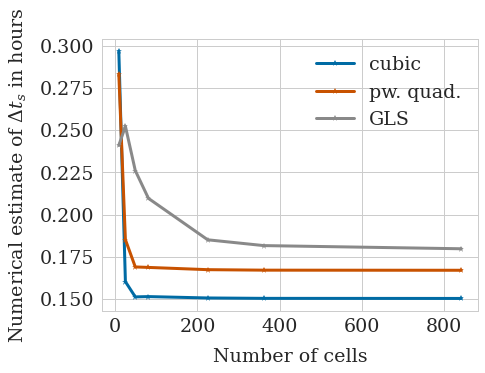

In [16]:
n_cells = [(2*l-1)*(l+(l-1)//2+l//2) for l in sl]
for force in force_names:
    plt.plot(n_cells, stability_bounds[force], '-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_s$ in hours')
plt.savefig('dependence_stability_n_cells.pdf', bbox_inches='tight')

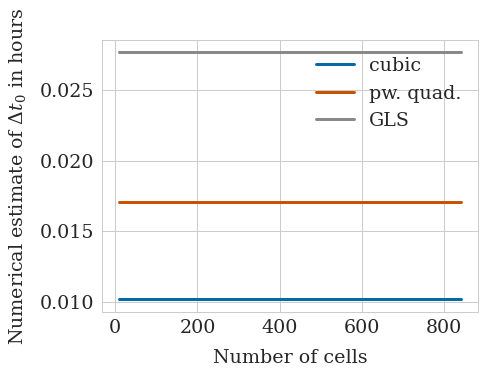

In [17]:
for force in force_names:
    plt.plot(n_cells, initial_step[force], label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_0$ in hours')
plt.savefig('dependence_initial_step_n_cells.pdf', bbox_inches='tight')

# Dependence of the initial step on epsilon

In [18]:
initial_step = {'cubic':[], 'pw. quad.': [], 'GLS': []}
sheet = make_hexagonal_mesh(4)

tolerances= [0.01, 0.001, 0.0001]
for eps in tolerances:
    
    for force in force_names:
    
        try:
            os.remove('step_sizes'+filename_ending[force]+'.txt')
            os.remove('time_points'+filename_ending[force]+'.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
    
        ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
        dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
        #print('Initial step '+force + ' ' +str(dts[0]))
        #print('Stability bound estimate '+force + ' ' +str(sbe))
        initial_step[force].append(dts[0])

        

Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.


Text(0, 0.5, 'Numerical estimate of $\\Delta t_0$ in hours')

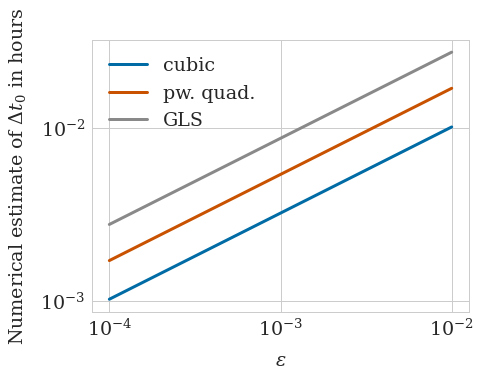

In [19]:
for force in force_names:
    plt.loglog(tolerances, initial_step[force], label=force, color=colors[force])

plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Numerical estimate of $\Delta t_0$ in hours')

# Plotting $\eta_k$ for a larger sheet

Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.
Nothing to delete.
Using global adaptive timestepping.


Text(0, 0.5, '$\\Delta t$ in hours')

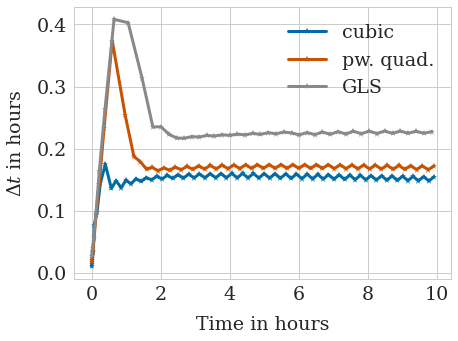

In [21]:
sheet = make_hexagonal_mesh(4)

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file' : True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
#    print('Initial step '+force + ' ' +str(dts[0]))
#    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
#    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])
plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
#plt.savefig('adaptivity_38cells.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_38cells.png', bbox_inches='tight')

In [22]:
AFs = np.loadtxt('AFs'+filename_ending['pw. quad.']+'.txt')
sorted_AFs = np.sort(AFs)


ValueError: Wrong number of columns at line 65

In [23]:
plt.plot(sorted_AFs[0,::-1], label='$t=\Delta t_0$')
plt.plot(sorted_AFs[1,::-1], label='$t=\Delta t_0+\Delta t_1$')
plt.plot(sorted_AFs[2,::-1], label='$t=\Delta t_0+\Delta t_1+\Delta t_2$')

plt.plot(sorted_AFs[-1,::-1], label='$t=t_f$')
plt.xlabel('k')
plt.ylabel('$|\eta_k|$, sorted decreasingly')
plt.legend()
plt.savefig('eta_k_pwq.pdf', bbox_inches='tight')

NameError: name 'sorted_AFs' is not defined